# Hot region complexity

In [1]:
%matplotlib inline

import os
import numpy as np
import math

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi

from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi
from xpsi.cellmesh.mesh_tools import eval_cedeCentreCoords

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 3.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported emcee version: 3.1.6
Imported PyMultiNest.
Imported UltraNest.
Imported GetDist version: 1.5.3
Imported nestcheck version: 0.2.1


Let's explore higher-complexity surface hot regions models. First we need to do some setup of the ambient spacetime and the surface embedded in it that the photosphere exists on.

In [2]:
bounds = dict(distance = (0.1, 1.0),                     # (Earth) distance
                mass = (1.0, 3.0),                       # mass
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                cos_inclination = (0.0, 1.0))      # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=300.0))

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


## Single-temperature hot regions

First we play with two hot regions that each have a single temperature component, meaning that the local comoving effective temperature is uniform within the hot region boundary. We instantiate hot region objects:

In [3]:
bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (0.0, 1.0),
              super_temperature = (None, None))

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(bounds=bounds,
                            values={}, # no fixed/derived variables
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False,
                            prefix='p')

bounds = dict(super_colatitude=(None,None),
              super_radius = (None, None),
              phase_shift = (0.0, 1.0),
              super_temperature = (None, None),
              omit_colatitude = (None, None),
              omit_radius = (None, None),
              omit_azimuth = (None, None))

# overlap of an omission region and
# and a radiating super region
secondary = xpsi.HotRegion(bounds=bounds,
                              values={}, # no fixed/derived variables
                              symmetry=True,
                              omit=True,
                              cede=False,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_antiphased=True,
                              prefix='s')

from xpsi import HotRegions

hot = HotRegions((primary, secondary))

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e+00].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" with bounds [3.000e+00, 7.600e+00].
    > log10(superseding region effective temperature [K]).
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000

Note that the ``{min,max}_sqrt_num_cells`` keyword arguments set the maximum number of elements that the vicinity of a hot region will be discretised into in both colatitude and azimuth.

Let's also explicitly fill the photosphere *elsewhere* with a simple radiation field. We will return to this later when we integrate over the surface radiation field to calculate signals.

In [4]:
elsewhere = xpsi.Elsewhere(bounds=dict(elsewhere_temperature = (None,None)))

Creating parameter:
    > Named "elsewhere_temperature" with bounds [3.000e+00, 7.600e+00].
    > log10 of the effective temperature elsewhere.


In [5]:
photosphere = xpsi.Photosphere(hot = hot, elsewhere = elsewhere,
                               values=dict(mode_frequency = spacetime['frequency']))

Creating parameter:
    > Named "mode_frequency" with fixed value 3.000e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


In [6]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

We will now define helper functions for plotting mesh representations, together with some plot settings. 

In [7]:
def plot_meshes(lines=(True,True),
                primary_ticks = (1,5),
                secondary_ticks = (1,5)):
    """ Plot representations of the cached meshes.
    
    Note that the lowest colatitude row of elements is plotted as the
    lowest row, so colatitude increases along the y-axis and azimuth
    increaes along the x-axis. This could be considered as spatially
    inverted if we were looking at the star whilst being oriented
    such that "up" is in the spin direction.
    
    """

    fig = plt.figure(figsize = (9, 19))

    gs = gridspec.GridSpec(2, 2, width_ratios=[50,1], wspace=0.1, hspace=0.1)
    ax = plt.subplot(gs[0,0])
    veneer(primary_ticks, primary_ticks, ax)

    # primary (lower colatitude) hot region
    z = hot.objects[0]._HotRegion__cellArea[0]/np.max(hot.objects[0]._HotRegion__cellArea[0])
    patches = plt.pcolormesh(z,
                             vmin = np.min(z),
                             vmax = np.max(z),
                             cmap = cm.magma,
                             linewidth = 1.0 if lines[0] else 0.0,
                             rasterized = True,
                             edgecolor='black')

    ax = plt.subplot(gs[1,0])
    veneer(secondary_ticks, secondary_ticks, ax)

    # secondary (higher colatitude) hot region
    z = hot.objects[1]._HotRegion__cellArea[0]/np.max(hot.objects[1]._HotRegion__cellArea[0])
    _ = plt.pcolormesh(z,
                       vmin = np.min(z),
                       vmax = np.max(z),
                       cmap = cm.magma,
                       linewidth = 1.0 if lines[1] else 0.0,
                       rasterized = True,
                       edgecolor='black')

    ax_cb = plt.subplot(gs[:,1])
    cb = plt.colorbar(patches,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label = r'cell area (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

In [8]:
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8, yticks=None):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        
    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')
    
    if yticks:
        axes.set_yticks(yticks)

Let's form a vector of parameter values in the *conventional* order expected by the ``Star`` instance and the other objects it encapsulates references to.

In [9]:
def set_defaults():
    global star # for clarity
    # (Earth) distance
    star['distance'] = 0.329 
    # gravitational mass
    star['mass'] = 1.4
    # coordinate equatorial radius
    star['radius'] = 13.18
    # (Earth) inclination to rotation axis
    star['cos_inclination'] = math.cos(1.0)
    # primary hot region (spot) centre colatitude
    star['p__super_colatitude'] = 2.19
    # primary spot angular radius
    star['p__super_radius'] = 0.0792
    # primary spot effective temperature
    star['p__super_temperature'] = 6.11
    # secondary hot region superseding member (SM) centre colatitude
    star['s__super_colatitude'] = math.pi/2.0
    # secondary hot region superseding member angular radius
    star['s__super_radius'] = 0.32                
    # secondary hot region omission centre colatitude
    star['s__omit_colatitude'] = math.pi/2.0
    # secondary hot region omission angular radius
    star['s__omit_radius'] = 0.25
    # secondary hot region omission centre relative azimuth 
    star['s__omit_azimuth'] = 0.0
    # secondary hot region effective temperature
    star['s__super_temperature'] = 6.12
    # elsewhere effective temperature
    star['elsewhere_temperature'] = 5.6
    
set_defaults()

We now prepare the star for pulse integration. In statistical contexts the likelihood function places this call automatically. The preparation involves embedding hot region objects into the photosphere (that also radiates elsewhere), by constructing element (or cell) meshes and precomputing ray mapping information for image integration. We place a call to our helper function to plot the meshes constructed: the mesh for the primary hot region is rendered in the topmost panel, with colour representing the proper area covered by the hot region within a given element. This area weights the pulse generated by an infinitesimal radiating element located at the proper-area-weighted centre of the element. The mesh associated with the secondary hot region is rendered in the bottommost panel.

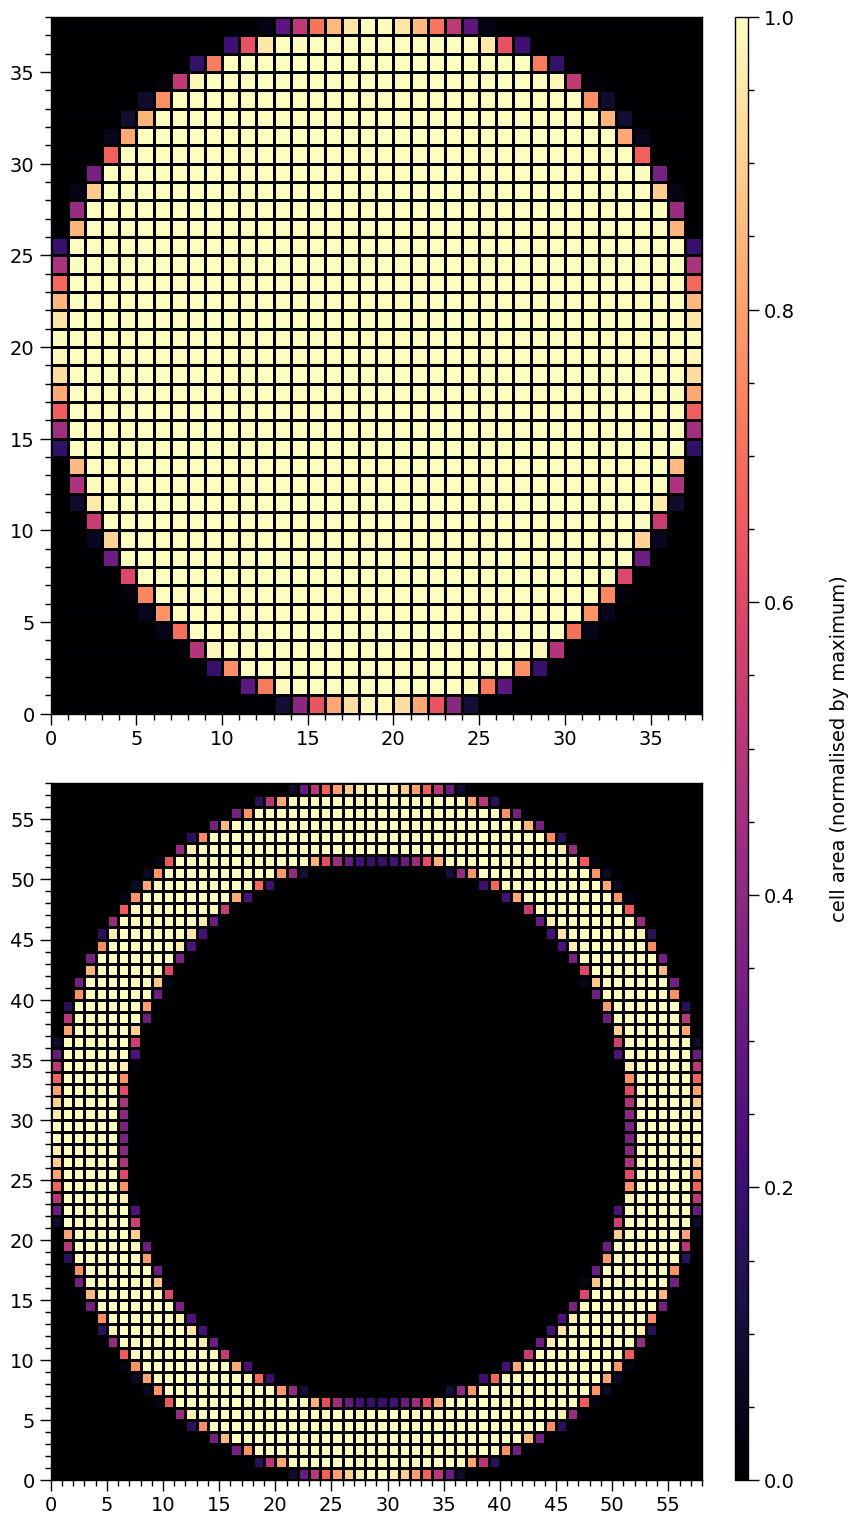

In [10]:
star.update()

plot_meshes()

We have a ring for secondary hot region. The hole would be automatically filled with the radiation field *elsewhere*, which might, e.g., be much cooler.

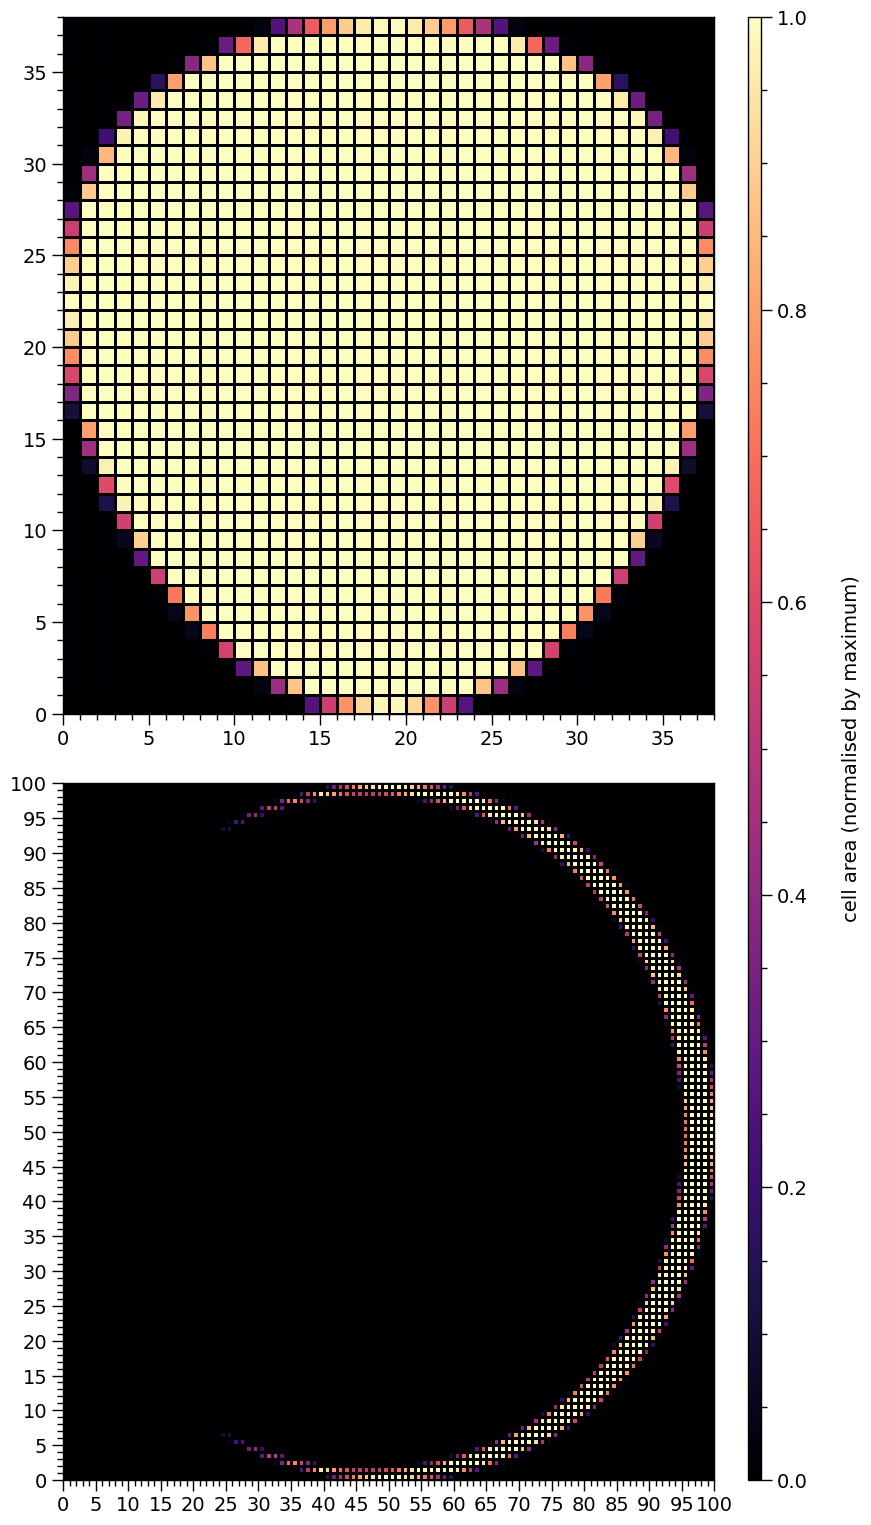

In [11]:
star['p__super_radius'] = 0.25   # increase the primary spot angular radius
star['s__omit_radius'] = 0.31    # increase the angular radius of the omission region
star['s__omit_azimuth'] = -0.02  # introduce a finite azimuthal omission offset

star.update()

plot_meshes()

We have a crescent that is symmetric about the equator. A way to think about this configuration is to consider the omission region as a a superseding member that supersedes a ceding member with the *elsewhere* radiation field.

Given that the superseding member is not a topological hole, the resulting crescent has *terminal points* or *horns*. As one approaches the horns around the crescent, the cell areas approach zero, and the two cells containing the two terminal points, and the adjacent cells cannot be resolved in colour from the cells that have zero coverage of the hot region. We can pick out these cells at the horns by setting a uniform colour for cells of finite area:

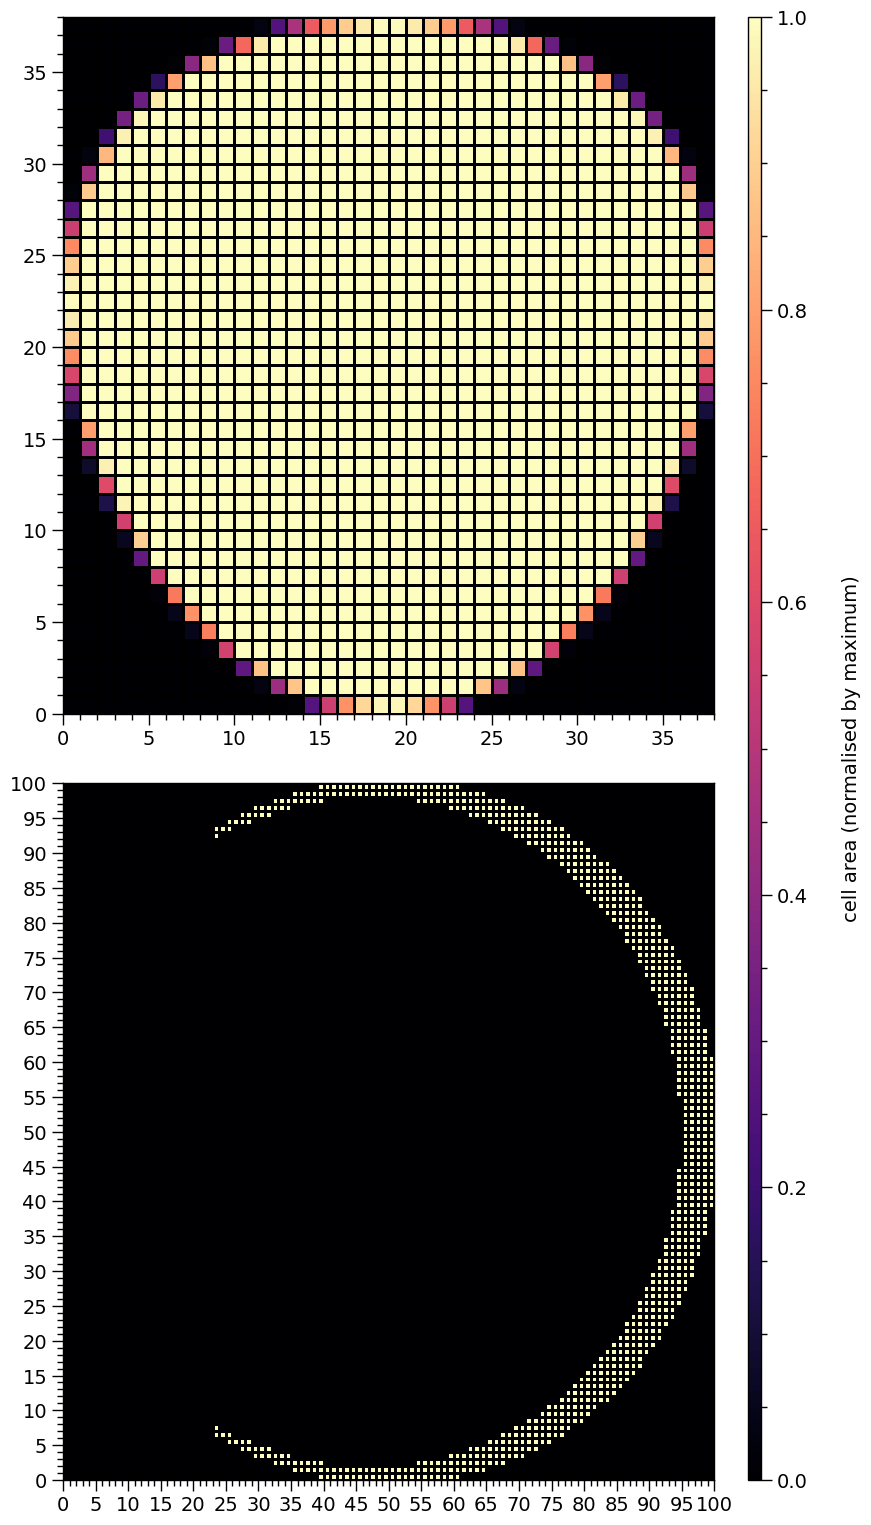

In [12]:
h = hot.objects[1]

# in the source code, there is always a radiating "super" region
# even if there is an omission region, it is equivalent to a
# non-radiating superseding member relative to a "super" region
# that is really a ceding member
h._super_cellArea[h._super_cellArea > 0.0] = 1.0

plot_meshes()

We can now see all cells with finite hot region coverage, and the symmetry is perhaps clearer.

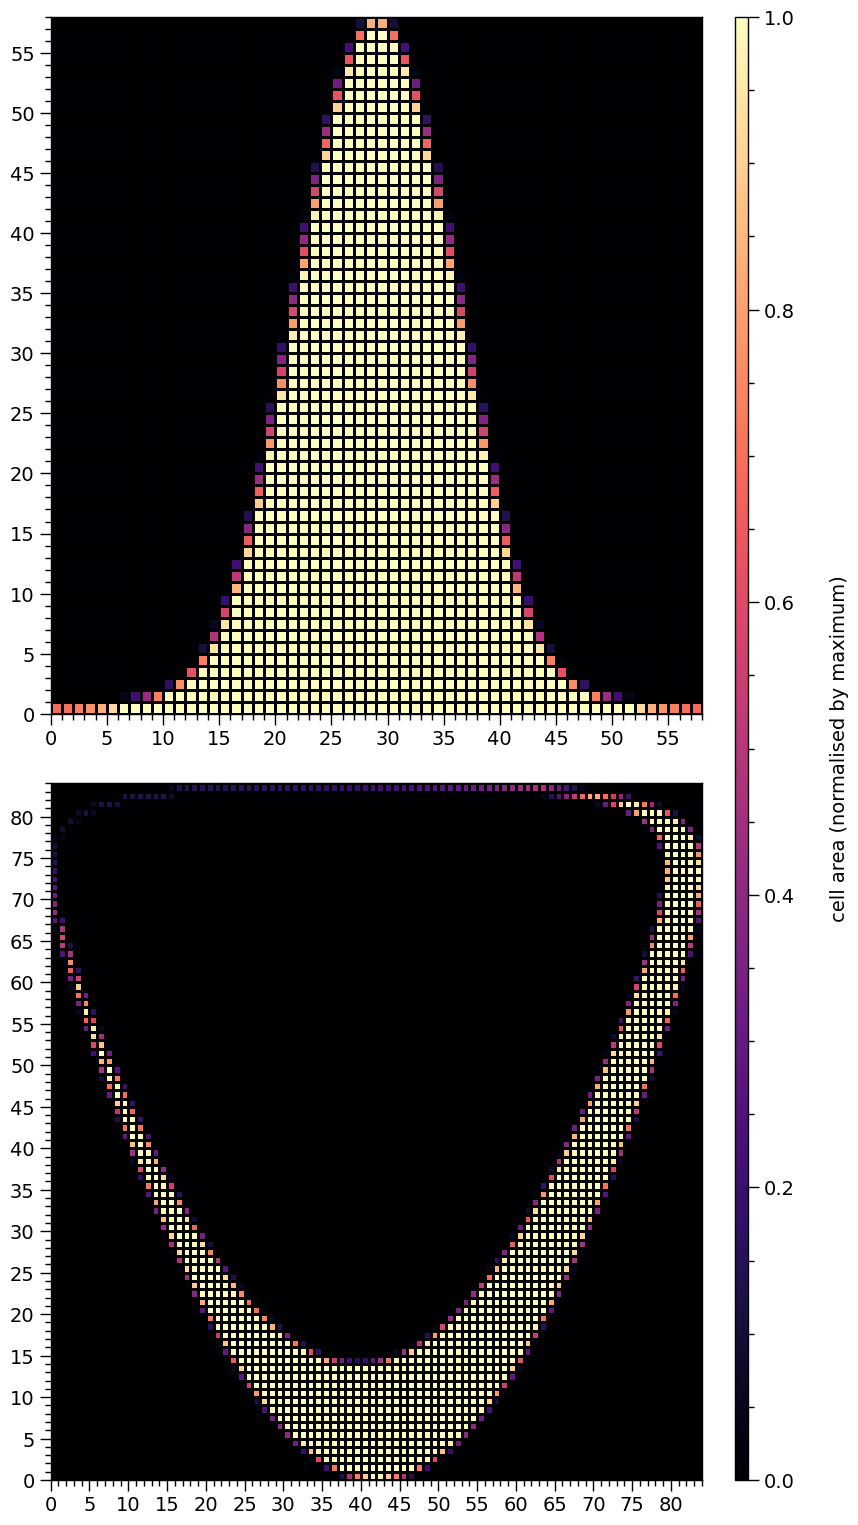

In [13]:
star['p__super_colatitude'] = 2.9     # increase the colatitude of the primary spot centre
star['p__super_radius'] = 0.3         # increase the angular radius of the primary spot
star['s__super_colatitude'] = 2.72    # this is not equal
star['s__omit_colatitude'] = 2.75     # to this any more
star['s__omit_radius'] = 0.284        #
star['s__omit_azimuth'] = -0.0483     # increase the magnitude of omission azimuthal offset

star.update()

plot_meshes()

Note that a fundamental property of the topmost mesh has now changed: the boundary in azimuth is periodic because the spot encompasses a pole (the southern rotational pole), whilst the lower boundary in colatitude is actually a coordinate singularity. The boundary in azimuth for the bottommost mesh is *not* periodic. The omission region is close enough to being a topological hole that we cannot distinguish whether or not it is from the mesh, and we would need to calulate the sum of the angular radius of the hole with the angular separation between the centres.

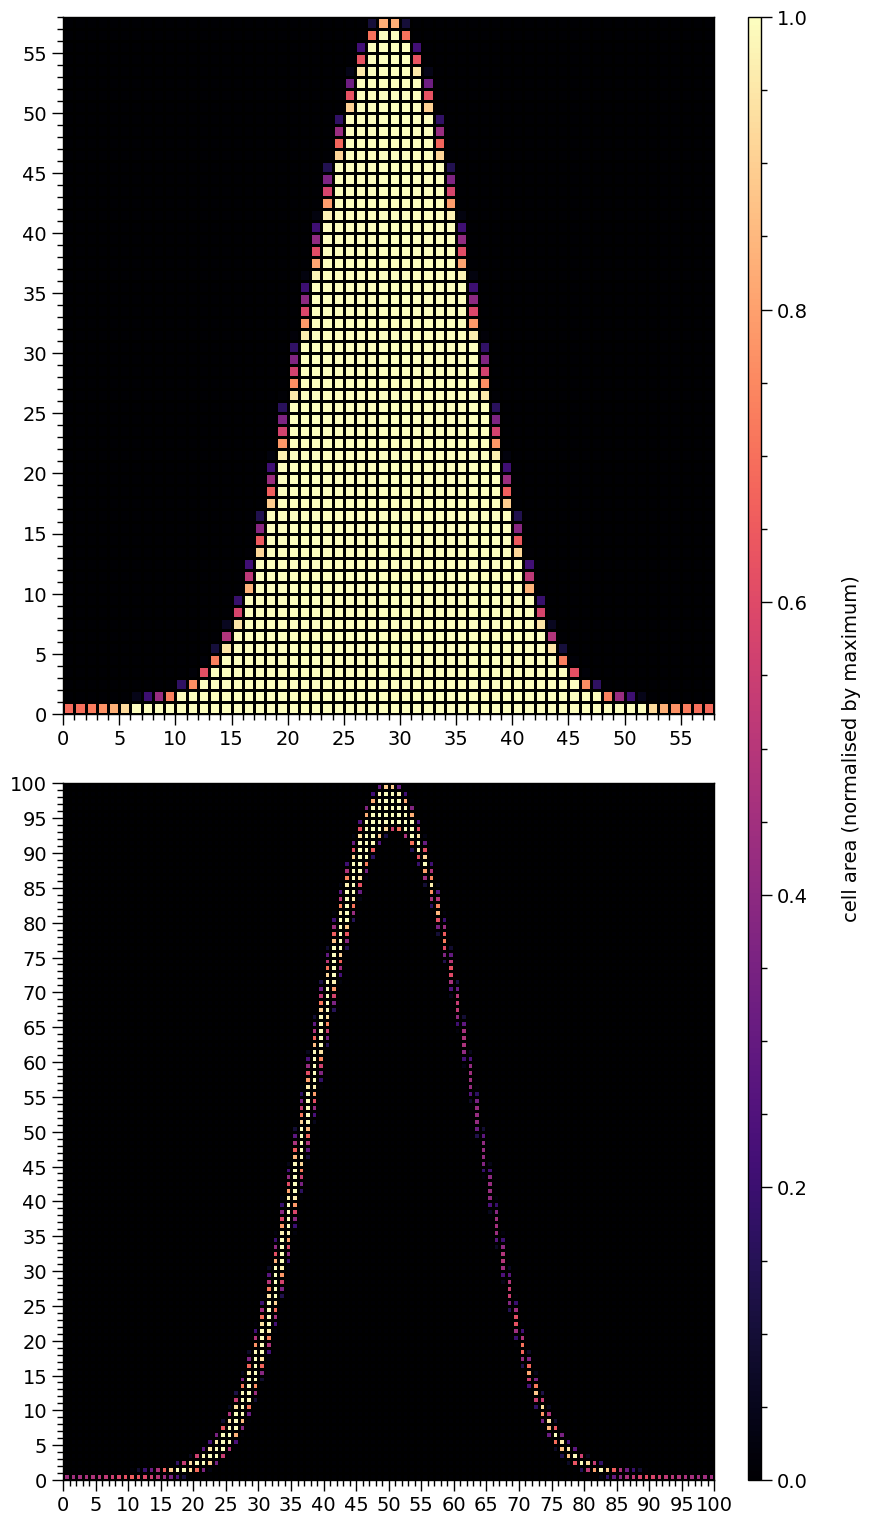

In [14]:
# changes:
# reflect primary spot w.r.t equator
# increase SM centre colatitude
# increase omission centre colatitude
# increase the omission region angular radius
# positive omission offset

star['p__super_colatitude'] = math.pi - 2.9                 
star['s__super_colatitude'] = 2.87                           
star['s__omit_colatitude'] = star['s__super_colatitude']     
star['s__omit_radius'] = 0.3                                 
star['s__omit_azimuth'] *= -1.0

star.update()

plot_meshes()

Note that although the primary spot was reflected about the equator, and now encompasses the northern rotation pole, the mesh does not look as though it has been reflected. Under the hood, the mesh for the primary spot encompassing the southern rotational pole is constructed as reflection about the equator, and then the mesh of colatitudes, which is not plotted but has the same shape as the mesh of proper areas (plotted), is transformed via $\theta\mapsto\pi-\theta$, leaving other reflection-symmetric properties intact. 

The mesh for the secondary hot region has now joined that of the primary in having a periodic boundary in azimuth. Note that the hole also encompasses the southern rotational pole.

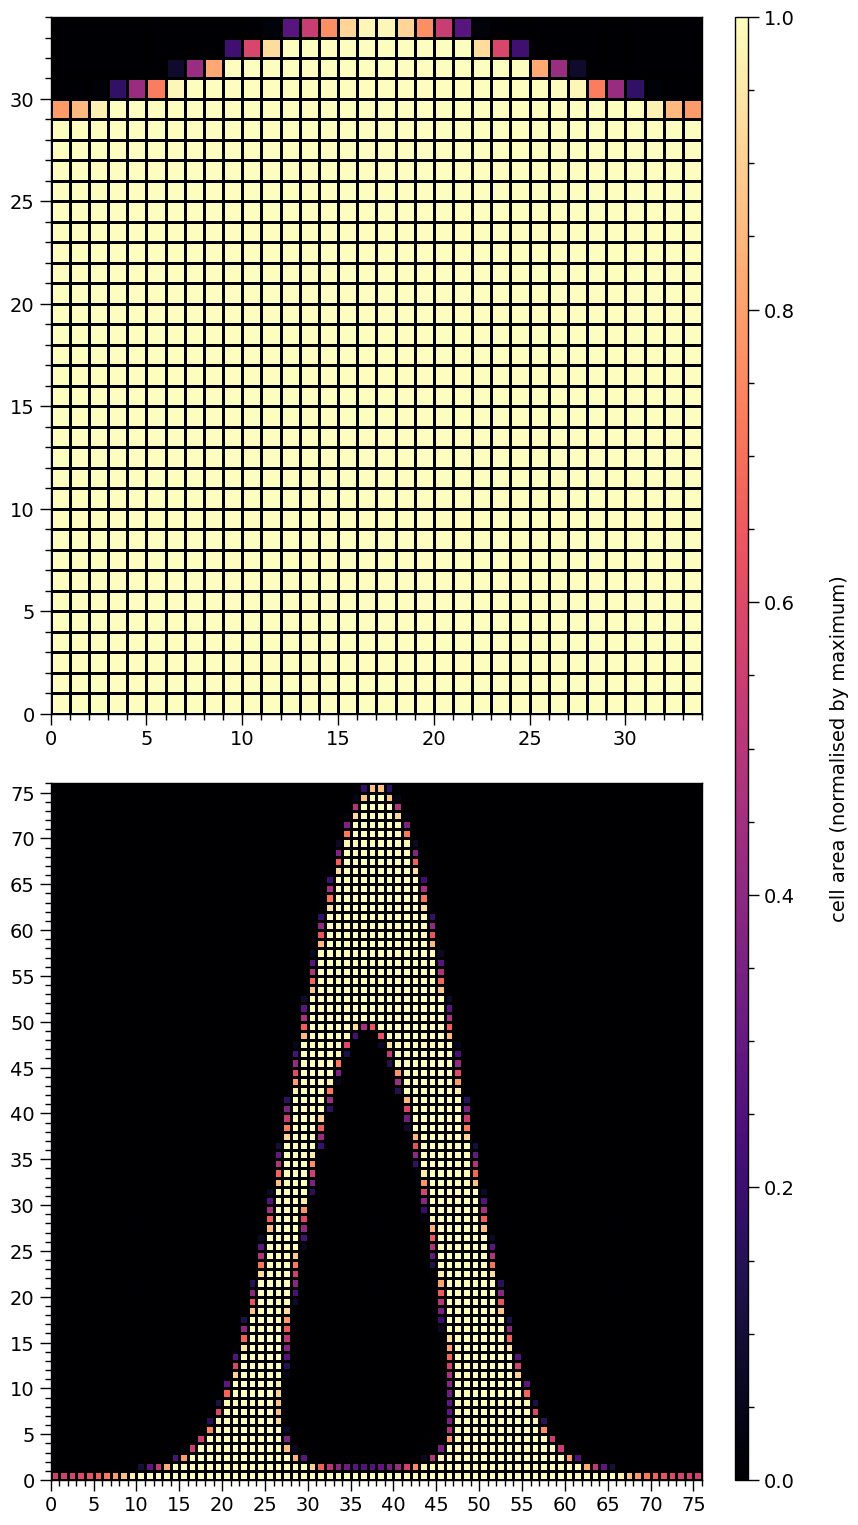

In [15]:
# changes:
# move primary spot centre almost to south pole
# move secondary hot region to encompass north pole
# decrease the angular radius of the omission region
# increase magnitude of omission region azimuthal offset

star['p__super_colatitude'] = math.pi - 0.01   
star['s__super_colatitude'] = 0.27            
star['s__super_radius'] = 0.32
star['s__omit_colatitude'] = 0.275
star['s__omit_radius'] = 0.2             
star['s__omit_azimuth'] = -0.1               

star.update()

plot_meshes()

The primary spot centre is now almost coincident with a pole, with the angular separation between pole and centre much smaller than the angular radius of the spot. Meanwhile, the omission member of the secondary hot region is a hole, but does not encompass a pole, whilst the outer boundary of the resulting ring *does*.

Let's increase the resolution for one of the examples above to some ridiculous level that is not even accurately rendered:

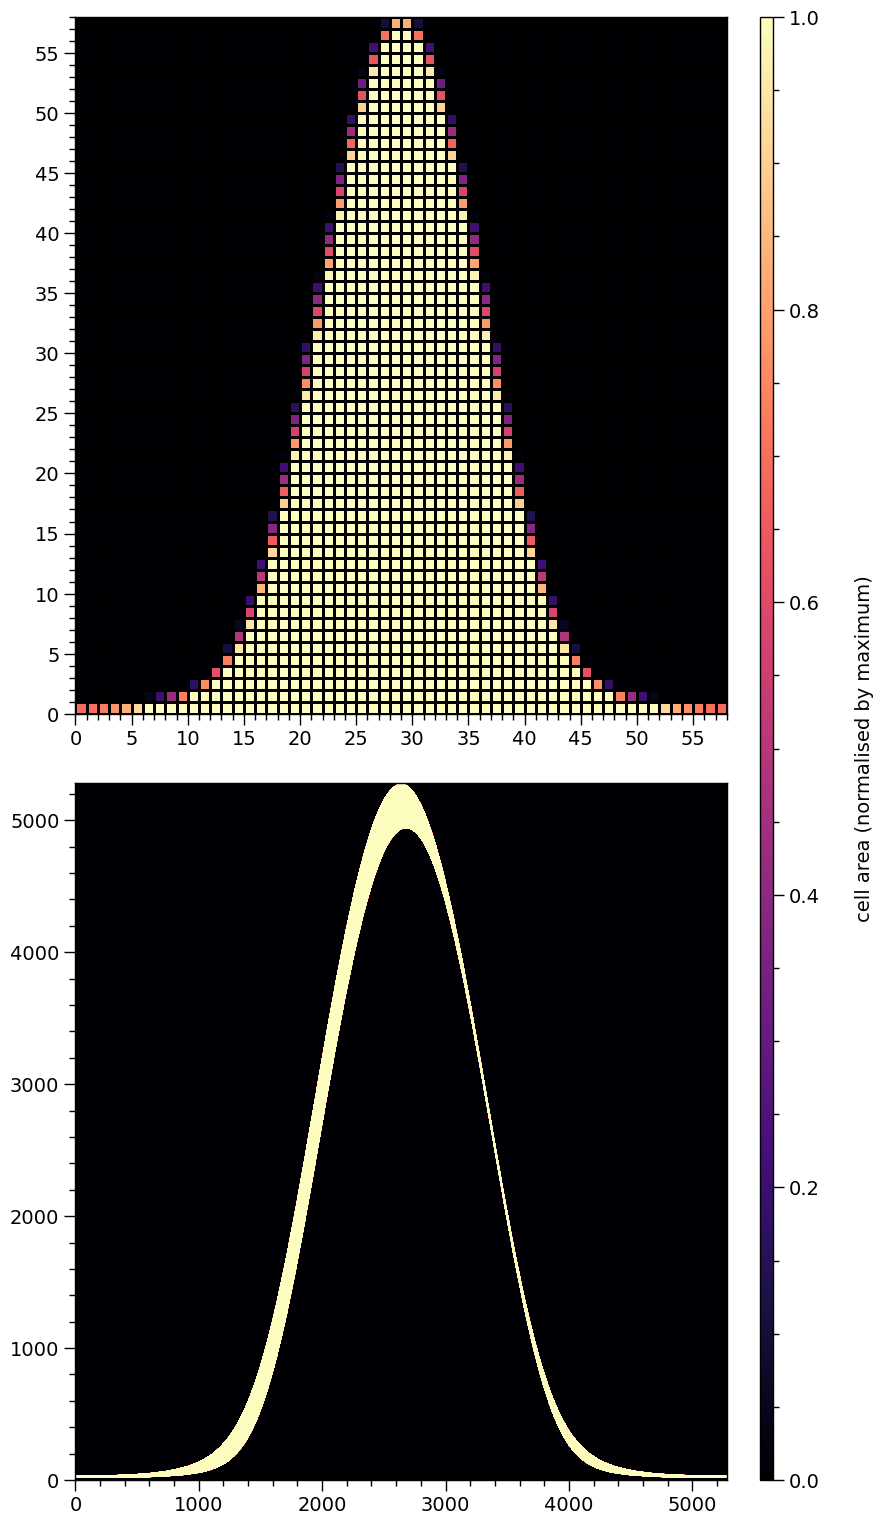

In [16]:
star['p__super_colatitude'] = math.pi - 2.9
star['p__super_radius'] = 0.3
star['s__super_colatitude'] = 2.87
star['s__super_radius'] = 0.32
star['s__omit_colatitude'] = star['s__super_colatitude']
star['s__omit_radius'] = 0.3
star['s__omit_azimuth'] = 0.0483   

h = hot.objects[1]

h.set_num_cells(sqrt_num_cells=1000, max_sqrt_num_cells=10000)

star.update()

plot_meshes(lines=(True, False), secondary_ticks=None)

There are other parametrisations that are useful to consider that might be more natural for prior implementation. The helper function below is an example.

In [17]:
def transform(p):
    """ Transform a parameter vector from a useful space to another.
    
    Specifically, the input vector ``p`` is constituted by:
    
        * the fractional angular offset between the centres of superseding and ceding members
        * the azimuthal offset of the ceding member about the centre of the superseding member
        
    An omission member is a non-radiating superseding region that *might* be a topological hole
    in the ceding member region.
        
    """
    global star # for clarity
    
    if star['s__omit_radius'] <= star['s__super_radius']:
        t1 = p[0] * (star['s__omit_radius'] + star['s__super_radius'])
    else:
        t1 = star['s__omit_radius'] - star['s__super_radius']
        t1 += 2.0*p[0]*star['s__super_radius']

    star['s__super_colatitude'], star['s__omit_azimuth'] \
            = eval_cedeCentreCoords(star['s__omit_colatitude'], t1, p[1])

    star['s__omit_azimuth'] *= -1.0

    return p

Let's try to recreate (approximately, although it can of course be done exactly by inverting the transformation) the crescent above that is symmetric with respect to the equator.

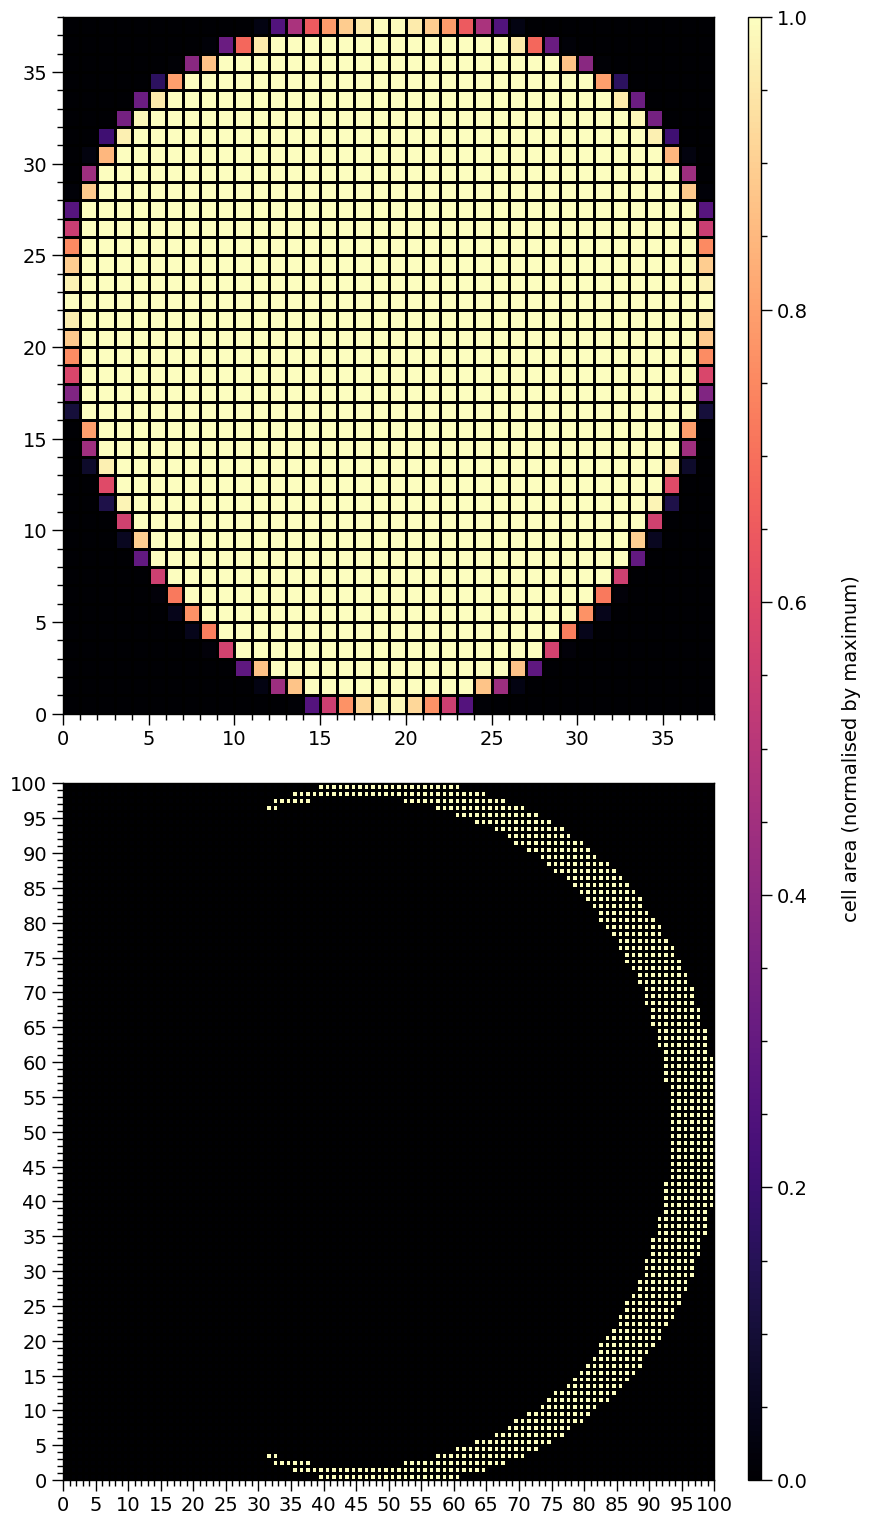

In [18]:
set_defaults()                            # defaults
star['p__super_radius'] = 0.25            # increase the primary spot angular radius
star['s__omit_radius'] = 0.31             # increase the angular radius of the omission region
star['s__omit_colatitude'] = math.pi/2.0

p = [0.05, math.pi/2.0]

transform(p)
       
h.set_num_cells(sqrt_num_cells=32, max_sqrt_num_cells=100)

star.update()

# make sure all elements with finite coverage are discernable
h = hot.objects[1]

# in the source code, there is always a radiating "super" region
# even if the omission region is equivalent to a non-radiating
# superseding member and the "super" region is then really a
# ceding member
h._super_cellArea[h._super_cellArea > 0.0] = 1.0

plot_meshes()

## Pulse integration

Let's compute some pulses. First we need a helper function.

In [19]:
from xpsi.tools import phase_interpolator

def plot_2D_pulse(z, x, shift, y, ylabel, 
                  num_rotations=5.0, res=5000, cm=cm.viridis,
                  yticks=None):
    """ Helper function to plot a phase-energy pulse.
    
    :param array-like z:
        A pair of *ndarray[m,n]* objects representing the signal at
        *n* phases and *m* values of an energy variable.
        
    :param ndarray[n] x: Phases the signal is resolved at.
        
    :param tuple shift: Hot region phase parameters.
    
    :param ndarray[m] x: Energy values the signal is resolved at.
    
    """
    
    fig = plt.figure(figsize = (12,6))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.025)
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    new_phases = np.linspace(0.0, num_rotations, res)

    interpolated = phase_interpolator(new_phases,
                                      x,
                                      z[0], shift[0],
                                      allow_negative=False)
    interpolated += phase_interpolator(new_phases,
                                       x,
                                       z[1], shift[1],
                                       allow_negative=True)

    profile = ax.pcolormesh(new_phases,
                             y,
                             interpolated/np.max(interpolated),
                             cmap = cm,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, 5.0])
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'Phase')
    veneer((0.1, 0.5), (None,None), ax, yticks=yticks)
    if yticks is not None:
        ax.set_yticklabels(yticks)
        
    cb = plt.colorbar(profile,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label=r'Signal (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

First we will make a configuration that resembles the first configuration in the **Modelling** notebook tutorial.

In [20]:
star['distance'] = 0.2
star['mass'] = 1.4
star['radius'] = 12.5
star['cos_inclination'] = math.cos(1.0)
star['p__super_colatitude'] = 1.0
star['p__super_radius'] = 0.075
star['p__super_temperature'] = 6.2
star['s__super_colatitude'] = math.pi - 1.0
star['s__super_radius'] = 0.2
star['s__omit_colatitude'] = math.pi - 1.0
star['s__omit_radius'] = 0.02               # make this smol
star['s__omit_azimuth'] = 0.0
star['s__super_temperature'] = 6.0
star['elsewhere_temperature'] = 3.0         # turn off

star.update()

Let's compute the incident specific flux signal normalised to the maximum. Note that if want to obtain the specific flux in units of photons/cm$^{2}$/s/keV instead, the output of ``photosphere.signal`` needs to be divided by distance squared, where distance is measured in meters.

In [21]:
energies = np.logspace(-2.0, np.log10(3.0), 1000, base=10.0)

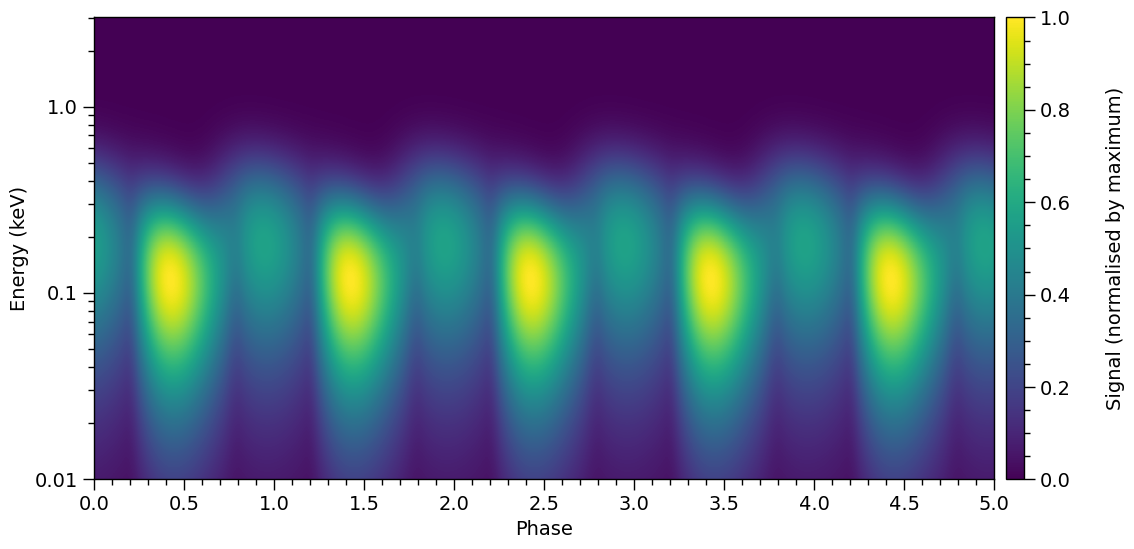

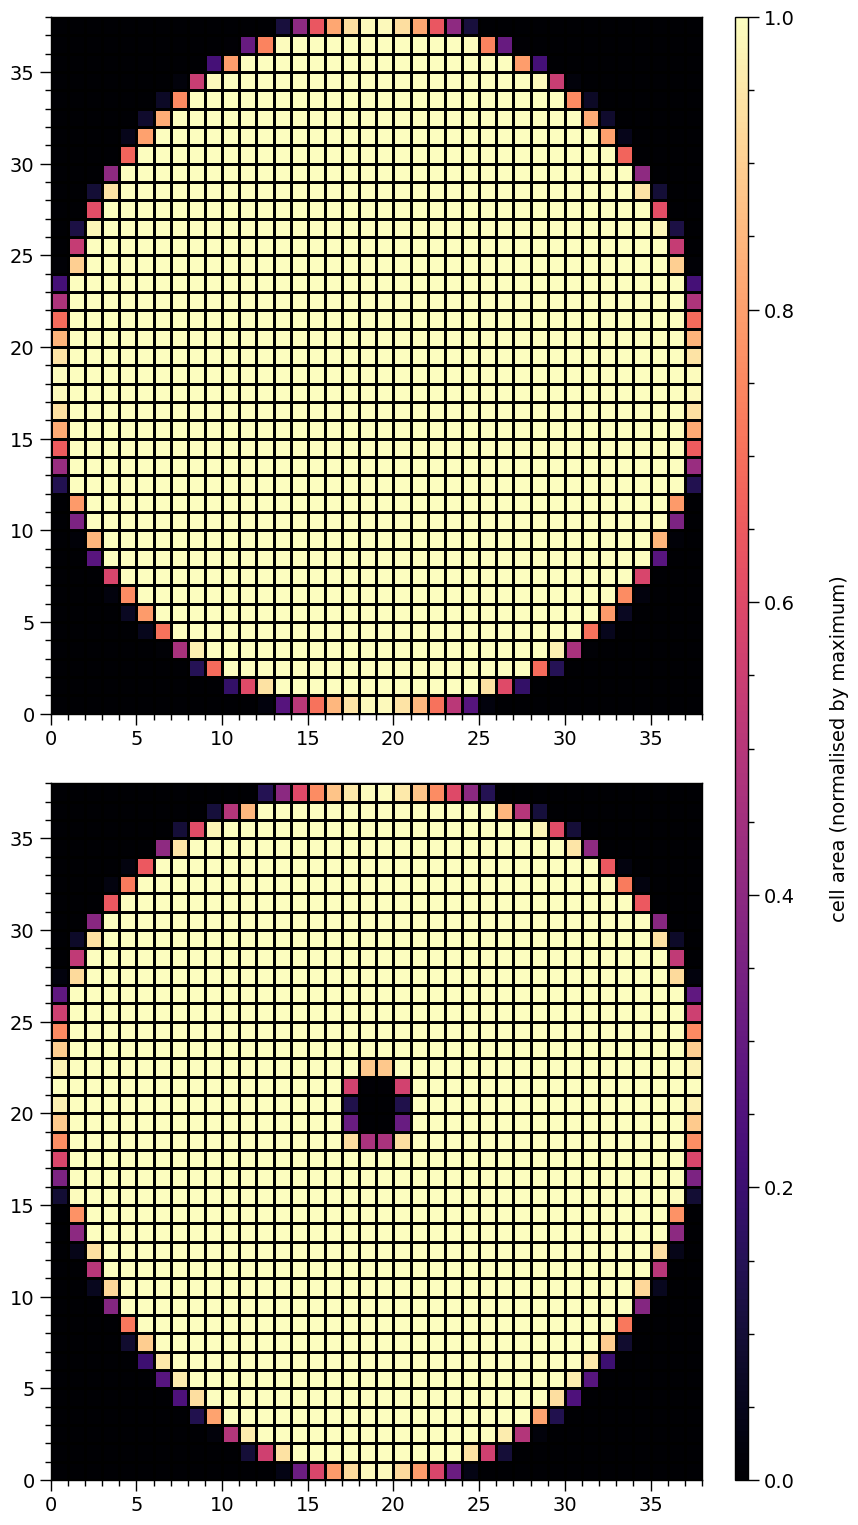

In [22]:
photosphere.integrate(energies=energies, threads=1)

plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[1][0]),
              x=hot.phases_in_cycles[0],
              shift=np.array([0.0,0.025]),
              y=energies,
              ylabel=r'Energy (keV)',
              yticks=[0.01,0.1,1.0])

plot_meshes()

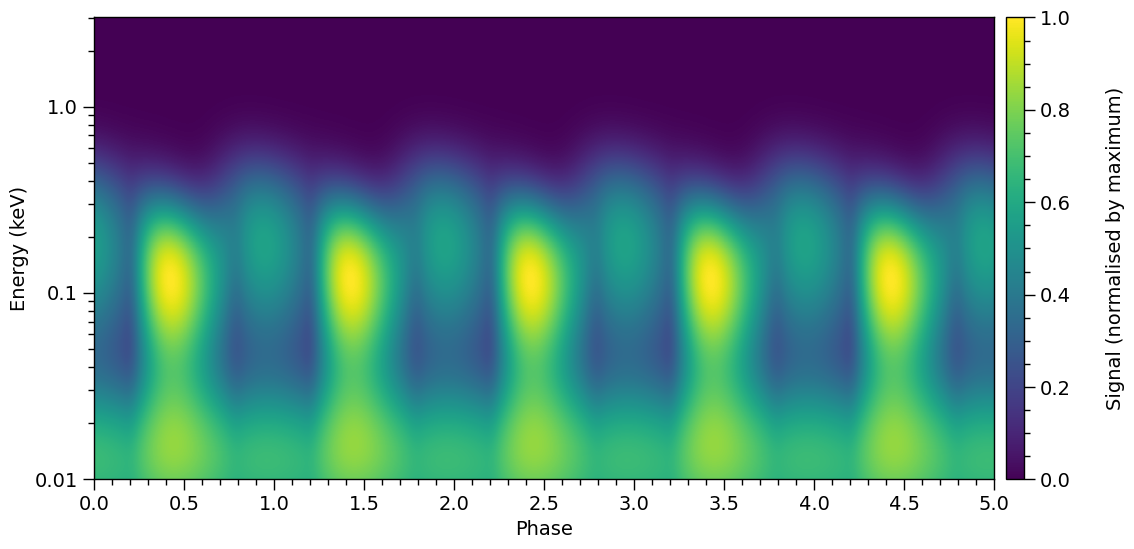

In [23]:
star['elsewhere_temperature'] = 5.0 

star.update()

photosphere.integrate(energies=energies, threads=1)

plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[1][0]),
              x=hot.phases_in_cycles[0],
              shift=np.array([0.0,0.025]),
              y=energies,
              ylabel=r'Energy (keV)',
              yticks=[0.01,0.1,1.0])

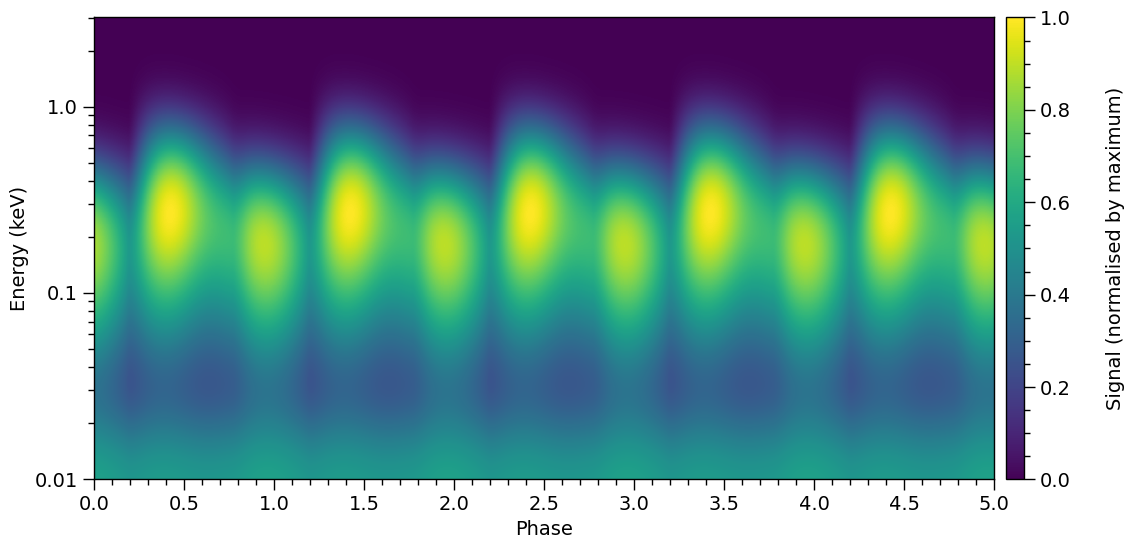

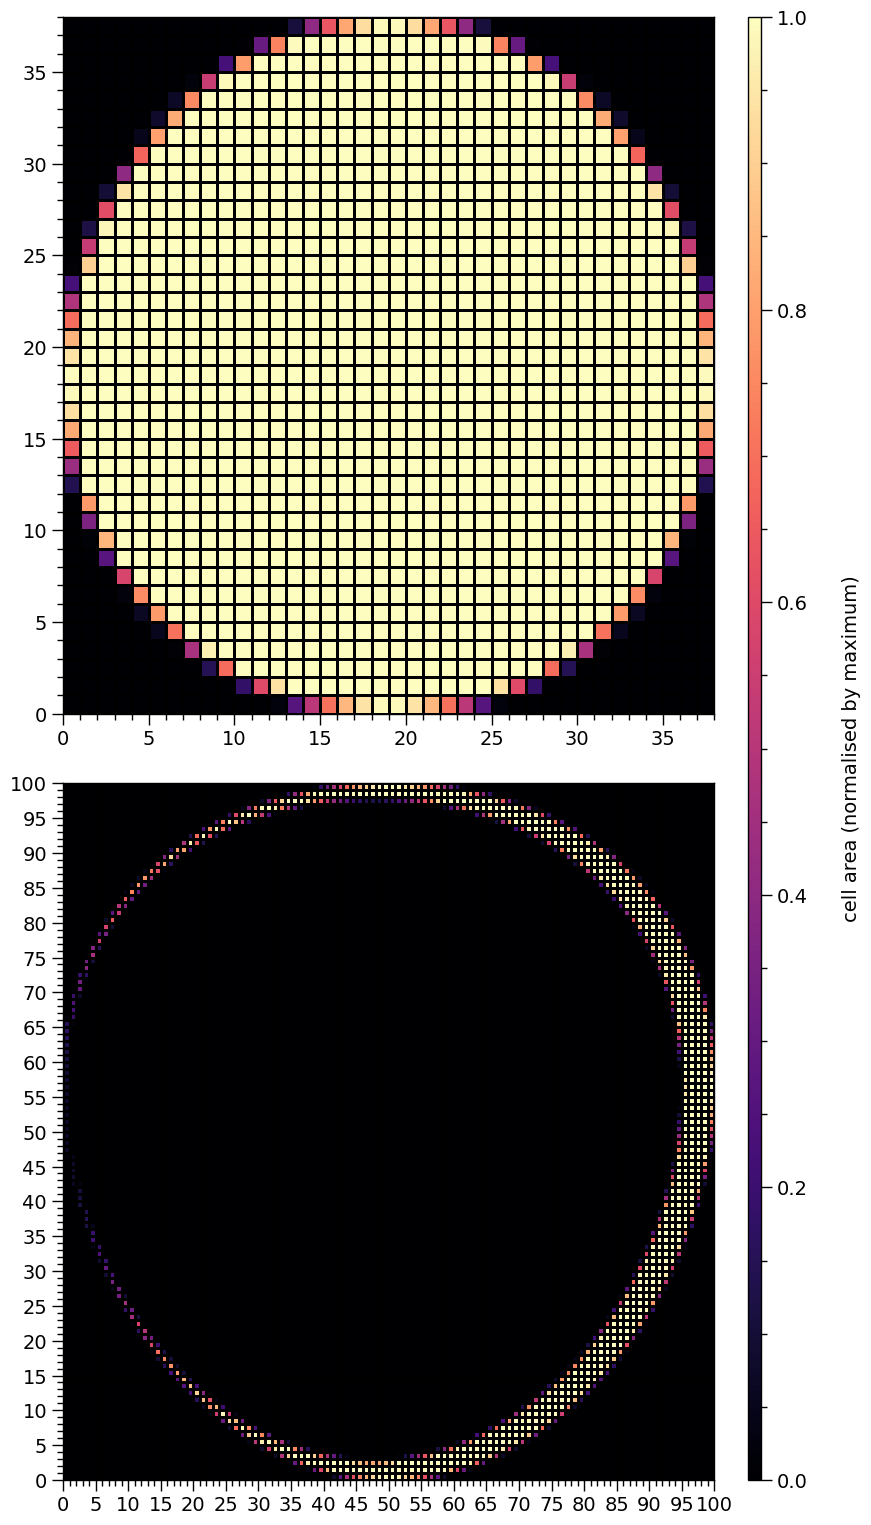

In [24]:
star['s__omit_radius'] = 0.95 * star['s__super_radius'] # not so small
star['s__super_temperature'] = 6.4                      # but brighter
star['elsewhere_temperature'] = 4.85                    # not so bright

p = [0.025, math.pi/2.0]

transform(p)

star.update(threads=4)

photosphere.integrate(energies=energies, threads=4)

plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[1][0]),
              x=hot.phases_in_cycles[0],
              shift=np.array([0.0, 0.0]), # zero shift
              y=energies,
              ylabel=r'Energy (keV)',
              yticks=[0.01,0.1,1.0])

plot_meshes()

## Two-temperature hot regions

Now we play with two hot regions which each have two temperature components. First we need to do the usual type of setup:

In [25]:
bounds = dict(super_colatitude=(None,None),
              super_radius = (None, None),
              phase_shift = (0.0, 1.0),
              super_temperature = (None, None),
              cede_colatitude = (None, None),
              cede_radius = (None, None),
              cede_azimuth = (None, None),
              cede_temperature = (None, None))


# overlap of a radiating superseding member region
# and a radiating ceding member region
primary = xpsi.HotRegion(bounds=bounds,
                            values={}, # no fixed/derived variables
                            symmetry=True,
                            omit=False,
                            cede=True,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False,
                            prefix='p')

# also an overlap of a radiating superseding member
# region and a radiating ceding member region
bounds = dict(super_colatitude=(None,None),
              super_radius = (None, None),
              phase_shift = (0.0, 1.0),
              super_temperature = (None, None),
              cede_colatitude = (None, None),
              cede_radius = (None, None),
              cede_azimuth = (None, None),
              cede_temperature = (None, None))

secondary = xpsi.HotRegion(bounds=bounds,
                              values={}, # no fixed/derived variables
                              symmetry=True,
                              omit=False,
                              cede=True,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_antiphased=True,
                              prefix='s')

from xpsi import HotRegions

hot = HotRegions((primary, secondary))

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e+00].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "cede_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the ceding region [radians].
Creating parameter:
    > Named "cede_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) ceding region [radians].
Creating parameter:
    > Named "cede_azimuth" with bounds [-3.142e+00, 3.142e+00].
    > The azimuth of the centre of the ceding region relative to the
centre of the superseding region [radians].
Creating parameter:
    > Named "supe

In [26]:
elsewhere = xpsi.Elsewhere(bounds=dict(elsewhere_temperature = (None,None)))

Creating parameter:
    > Named "elsewhere_temperature" with bounds [3.000e+00, 7.600e+00].
    > log10 of the effective temperature elsewhere.


In [27]:
photosphere = xpsi.Photosphere(hot = hot, elsewhere = elsewhere,
                               values=dict(mode_frequency = spacetime['frequency']))

Creating parameter:
    > Named "mode_frequency" with fixed value 3.000e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


In [28]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

Let's define a different helper function for plotting the meshes:

In [29]:
def plot_meshes(lines=(True,True),
                primary_ticks = (1,5),
                secondary_ticks = (1,5)):
    """ Plot representations of the cached meshes.
    
    Note that the lowest colatitude row of elements is plotted as the
    lowest row, so colatitude increases along the y-axis and azimuth
    increaes along the x-axis. This could be considered as spatially
    inverted if we were looking at the star whilst being oriented
    such that "up" is in the spin direction.
    
    """

    fig = plt.figure(figsize = (10, 10))

    gs = gridspec.GridSpec(2, 3, width_ratios=[50,50, 1], wspace=0.25, hspace=0.15)
    ax = plt.subplot(gs[0,0])
    veneer(primary_ticks, primary_ticks, ax)

    # primary (lower colatitude) superseding
    z = hot.objects[0]._HotRegion__cellArea[0]/np.max(hot.objects[0]._HotRegion__cellArea[0])
    patches = plt.pcolormesh(z,
                             vmin = np.min(z),
                             vmax = np.max(z),
                             cmap = cm.magma,
                             linewidth = 1.0 if lines[0] else 0.0,
                             rasterized = True,
                             edgecolor='black')

    ax = plt.subplot(gs[1,0])
    veneer(secondary_ticks, secondary_ticks, ax)

    # primary ceding
    z = hot.objects[0]._HotRegion__cellArea[1]/np.max(hot.objects[0]._HotRegion__cellArea[1])
    _ = plt.pcolormesh(z,
                       vmin = np.min(z),
                       vmax = np.max(z),
                       cmap = cm.magma,
                       linewidth = 1.0 if lines[1] else 0.0,
                       rasterized = True,
                       edgecolor='black')
    
    ax = plt.subplot(gs[0,1])
    veneer(primary_ticks, primary_ticks, ax)

    # secondary superseding
    z = hot.objects[1]._HotRegion__cellArea[0]/np.max(hot.objects[1]._HotRegion__cellArea[0])
    patches = plt.pcolormesh(z,
                             vmin = np.min(z),
                             vmax = np.max(z),
                             cmap = cm.magma,
                             linewidth = 1.0 if lines[0] else 0.0,
                             rasterized = True,
                             edgecolor='black')

    ax = plt.subplot(gs[1,1])
    veneer(secondary_ticks, secondary_ticks, ax)

    # secondary ceding
    z = hot.objects[1]._HotRegion__cellArea[1]/np.max(hot.objects[1]._HotRegion__cellArea[1])
    _ = plt.pcolormesh(z,
                       vmin = np.min(z),
                       vmax = np.max(z),
                       cmap = cm.magma,
                       linewidth = 1.0 if lines[1] else 0.0,
                       rasterized = True,
                       edgecolor='black')

    ax_cb = plt.subplot(gs[:,2])
    cb = plt.colorbar(patches,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label = r'cell area (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

In [30]:
def set_defaults():
    """ Default configuration is antipodally reflection symmetric. """
    # (Earth) distance
    star['distance'] = 0.329 
    # gravitational mass
    star['mass'] = 1.4
    # coordinate equatorial radius
    star['radius'] = 13.18
    # (Earth) inclination to rotation axis
    star['cos_inclination'] = math.cos(1.0)
    
    # primary super colatitude
    star['p__super_colatitude'] = math.pi/2.0
    # primary super angular radius
    star['p__super_radius'] = 0.25               
    # primary cede colatitude
    star['p__cede_colatitude'] = math.pi/2.0
    # primary cede angular radius
    star['p__cede_radius'] = 0.32
    # primary cede azimuthal offset 
    star['p__cede_azimuth'] = 0.0
    # primary super temp
    star['p__super_temperature'] = 6.12
    # primary cede temp
    star['p__cede_temperature'] = 6.0
    
    # secondary super colatitude
    star['s__super_colatitude'] = math.pi/2.0
    # secondary super angular radius
    star['s__super_radius'] = 0.25                
    # secondary cede colatitude
    star['s__cede_colatitude'] = math.pi/2.0
    # secondary cede angular radius
    star['s__cede_radius'] = 0.32
    # secondary cede azimuthal offset 
    star['s__cede_azimuth'] = 0.0
    # secondary super temp
    star['s__super_temperature'] = 6.12
    # secondary cede temp
    star['s__cede_temperature'] = 6.0
    
    # elsewhere effective temperature
    star['elsewhere_temperature'] = 5.0
    
set_defaults()

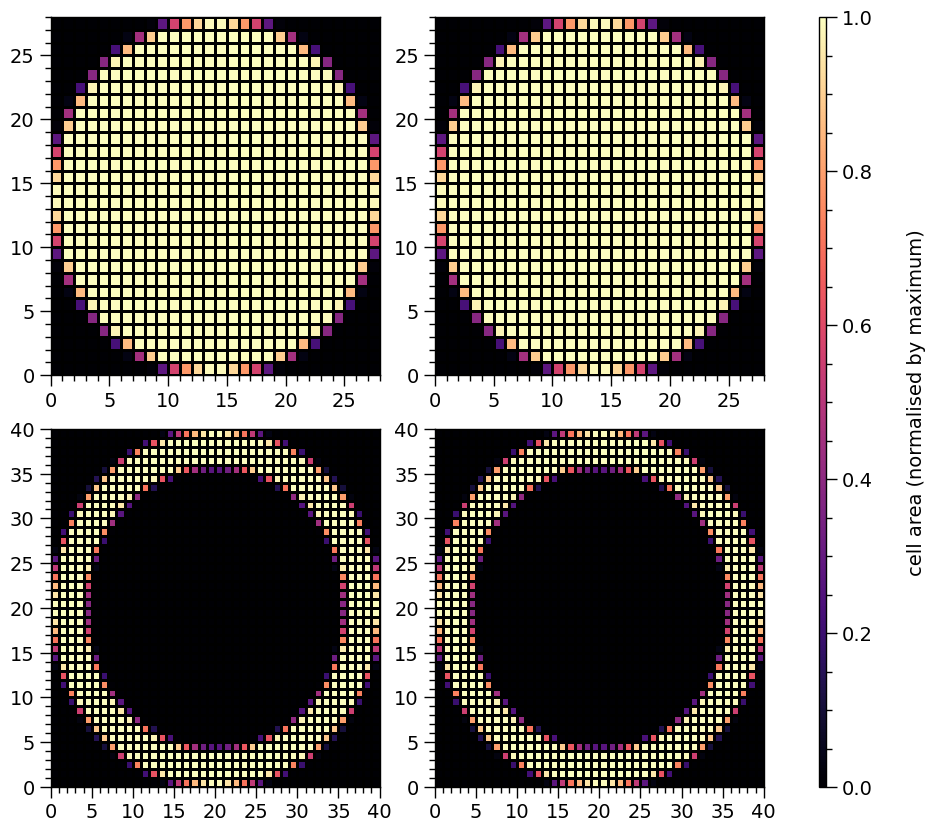

In [31]:
star.update()

plot_meshes()

The leftmost panels are the meshes associated with the primary hot region, whilst the rightmost panels are the meshes associated with the secondary hot region. The topmost panels are the meshes associated with the superseding members, whilst the bottommost panels are the meshes associated with the ceding members.

Let's play with the hot regions:

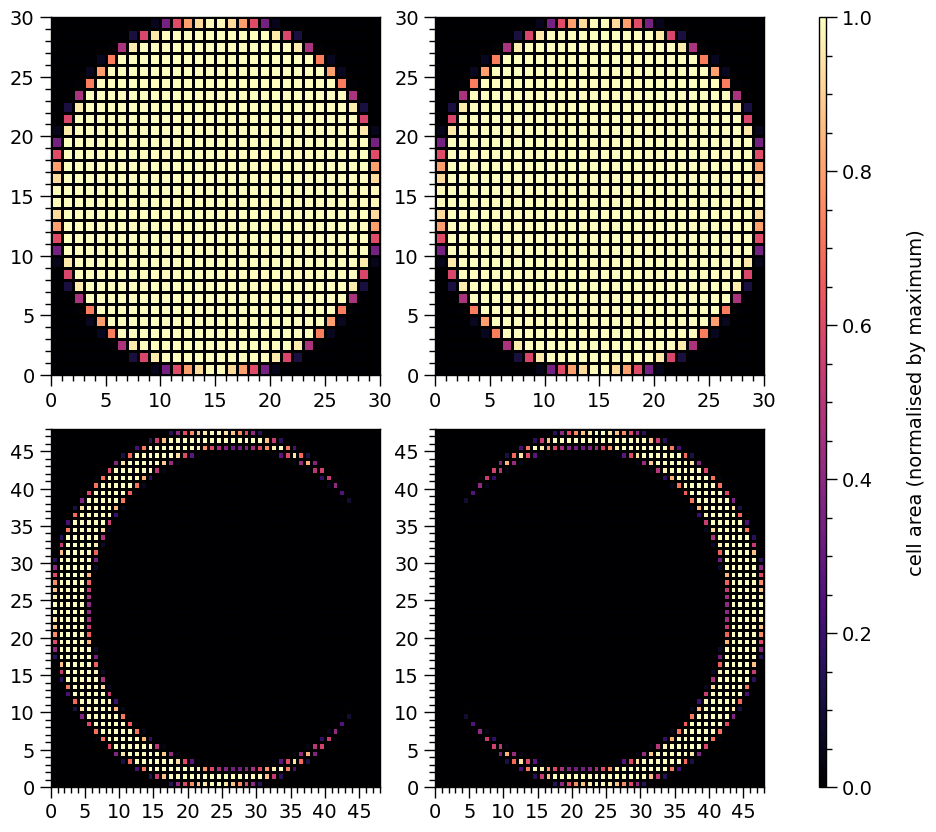

In [32]:
star['p__cede_azimuth'] = -0.04
star['s__cede_azimuth'] = 0.04

star['p__super_radius'] = star['s__super_radius'] = 0.9*star['s__cede_radius']

star.update()

plot_meshes()

Let's move them to opposite poles:

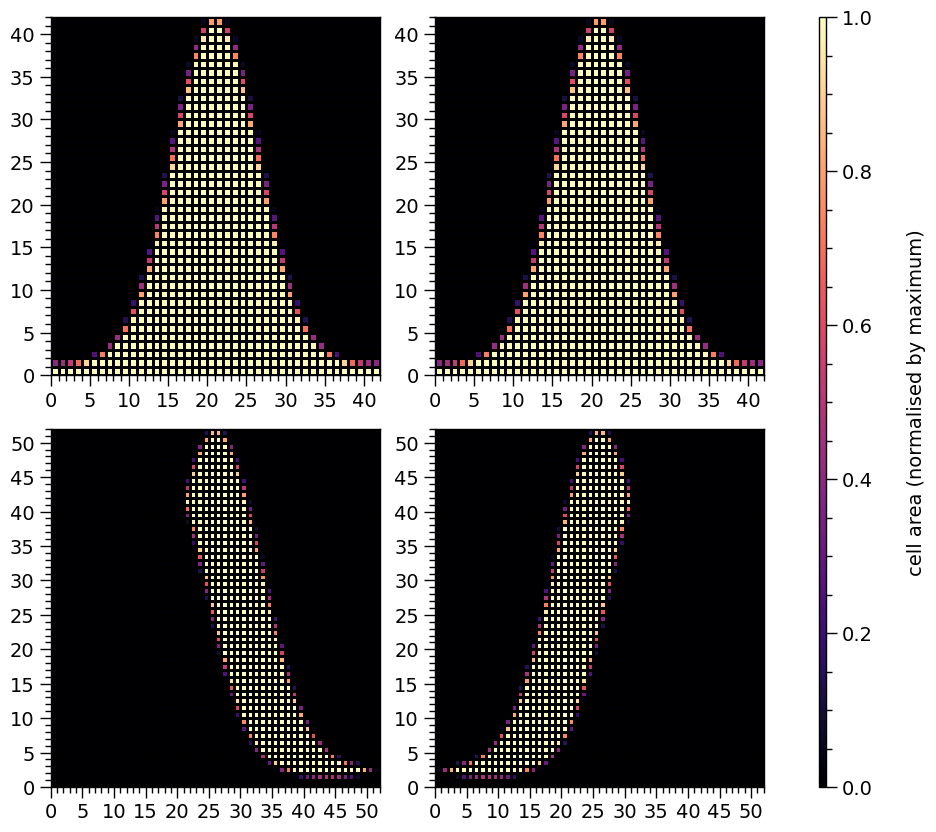

In [33]:
star['p__super_colatitude'] = star['p__cede_colatitude'] = math.pi - 0.2

star['s__cede_colatitude'] = star['s__super_colatitude'] = 0.2

star['p__cede_azimuth'] = 1.0
star['s__cede_azimuth'] = -1.0

star.update()

plot_meshes()

Let's move them so that they do not encompass the poles and the meshes are inverted:

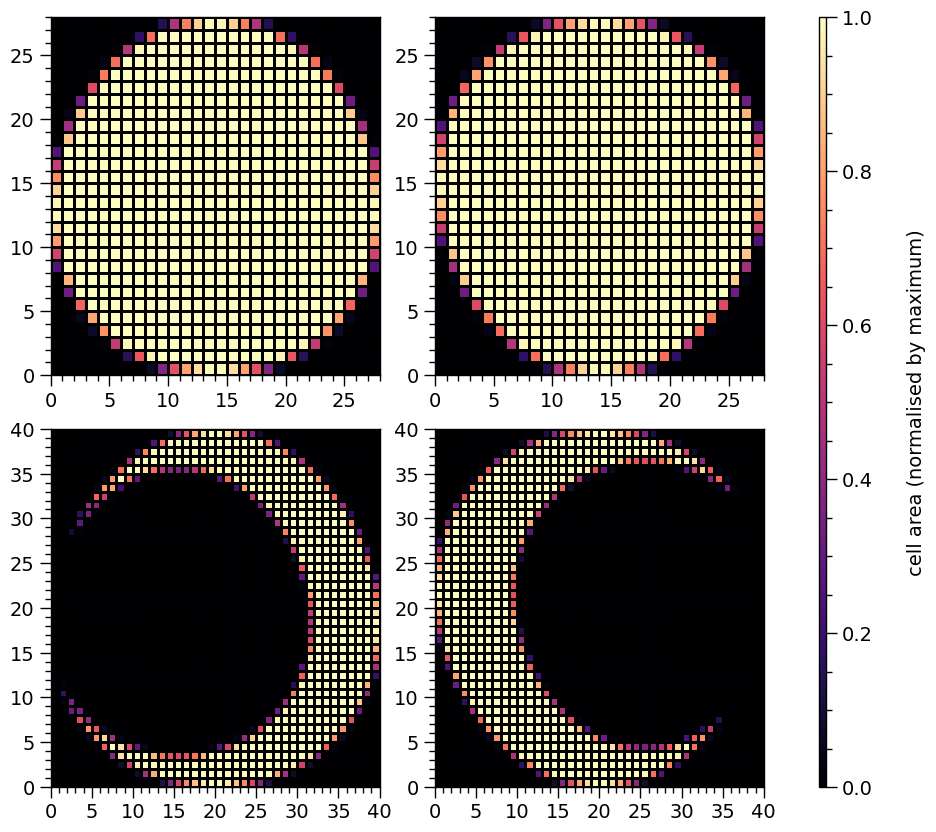

In [34]:
star['p__super_colatitude'] = star['p__cede_colatitude'] = 1.0

star['s__cede_colatitude'] = star['s__super_colatitude'] = math.pi - 1.0

star['p__cede_azimuth'] = 0.04
star['s__cede_azimuth']  = -0.05

star['p__cede_radius']  = star['s__cede_radius'] = 0.15
star['p__super_radius'] = star['s__super_radius'] = 0.8*star['s__cede_radius']

star.update()

plot_meshes()

Finally, let's integrate a pulse:

In [35]:
energies = np.logspace(-2.0, np.log10(3.0), 1000, base=10.0)

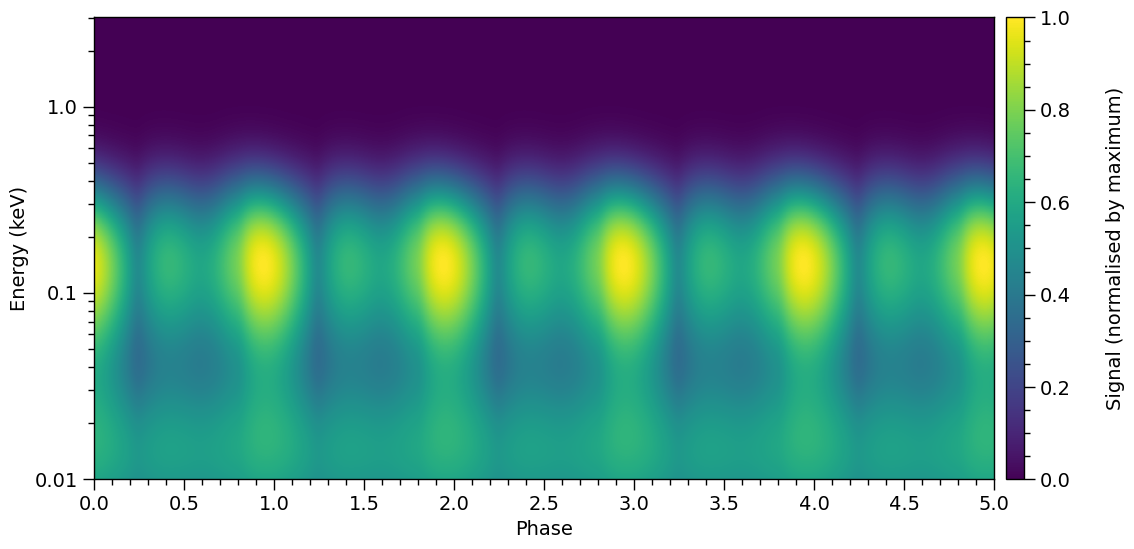

In [36]:
star['elsewhere_temperature'] = 5.0

star.update()

photosphere.integrate(energies=energies, threads=4)

plot_2D_pulse((photosphere.signal[0][0] + photosphere.signal[0][1],
               photosphere.signal[1][0] + photosphere.signal[1][1]),
              x=hot.phases_in_cycles[0],
              shift=np.array([0.0,0.0]),
              y=energies,
              ylabel=r'Energy (keV)',
              yticks=[0.01,0.1,1.0])

Let's have a play with the temperatures, so show that the signal from *elsewhere* is affected by the now *cool* localised regions.

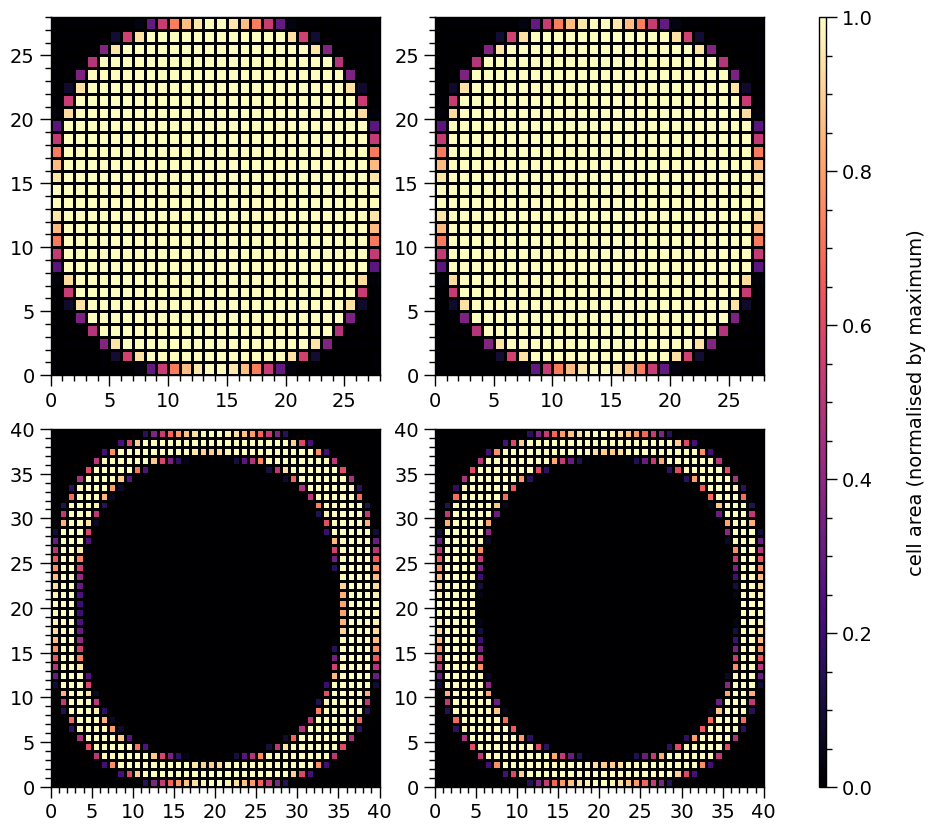

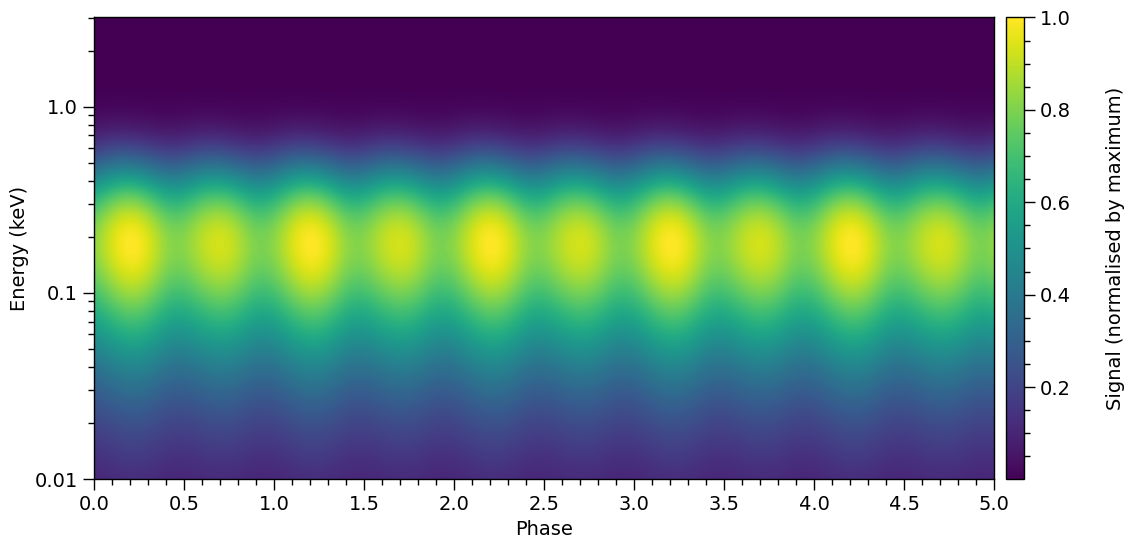

In [37]:
star['elsewhere_temperature'] = 6.2

star['p__super_temperature'] = star['p__cede_temperature'] \
    = star['s__super_temperature'] = star['s__cede_temperature'] = 3.0

star['p__super_colatitude'] = star['p__cede_colatitude'] = math.pi/2.0

star['s__cede_colatitude'] = star['s__super_colatitude'] = math.pi/2.0

star['p__cede_radius'] = star['s__cede_radius'] = 1.0
star['p__super_radius'] = star['s__super_radius'] = 0.8*star['s__cede_radius']

star.update()

plot_meshes()

photosphere.integrate(energies=energies, threads=4)

plot_2D_pulse((photosphere.signal[0][0] + photosphere.signal[0][1],
               photosphere.signal[1][0] + photosphere.signal[1][1]),
              x=hot.phases_in_cycles[0],
              shift=np.array([0.0,0.0]),
              y=energies,
              ylabel=r'Energy (keV)',
              yticks=[0.01,0.1,1.0])

Notice the phase shift relative to the previous pulse plot? The local maxima now are shifted by $\sim\!0.25$ cycles.